# 安徽安庆市项目`WRF-CMAQ`模拟分析
## Spatial Distribution : `chem-obs data`

---
*@author: Evan*\
*@date: 2023-05-07*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 读取数据

In [2]:
# chemFile=xr.open_dataset('F:/Data/case_anqing/compressed_chem.nc')
metFile=xr.open_dataset('F:/Data/case_anqing/April/April_met.nc')
gridFile = xr.open_dataset('F:/Data/case_anqing/GRIDCRO2D_2023021.nc')

In [3]:
lat = gridFile.LAT.squeeze()
lon = gridFile.LON.squeeze()

uw_L1 = np.squeeze(metFile.uwind.sel(level=1000,method='nearest'))
vw_L1 = np.squeeze(metFile.vwind.sel(level=1000,method='nearest'))

uw_L2 = np.squeeze(metFile.uwind.sel(level=850,method='nearest'))
vw_L2 = np.squeeze(metFile.vwind.sel(level=850,method='nearest'))

uuL1 = uw_L1.resample({'time':'D'}).mean(dim='time')
vvL1 = vw_L1.resample({'time':'D'}).mean(dim='time')

uuL2 = uw_L2.resample({'time':'D'}).mean(dim='time')
vvL2 = vw_L2.resample({'time':'D'}).mean(dim='time')

print('lat & lon = ',lat.shape)
print('chem      = ',uuL1.shape)

lat & lon =  (138, 135)
chem      =  (30, 138, 135)


In [4]:
ws_L1 = np.sqrt(uuL1**2+vvL1**2)
ws_L2 = np.sqrt(uuL2**2+vvL2**2)

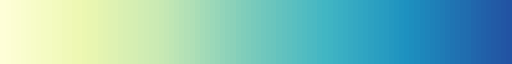

In [5]:
import cmaps

colormap = cmaps.MPL_YlGnBu[:100]
colormap

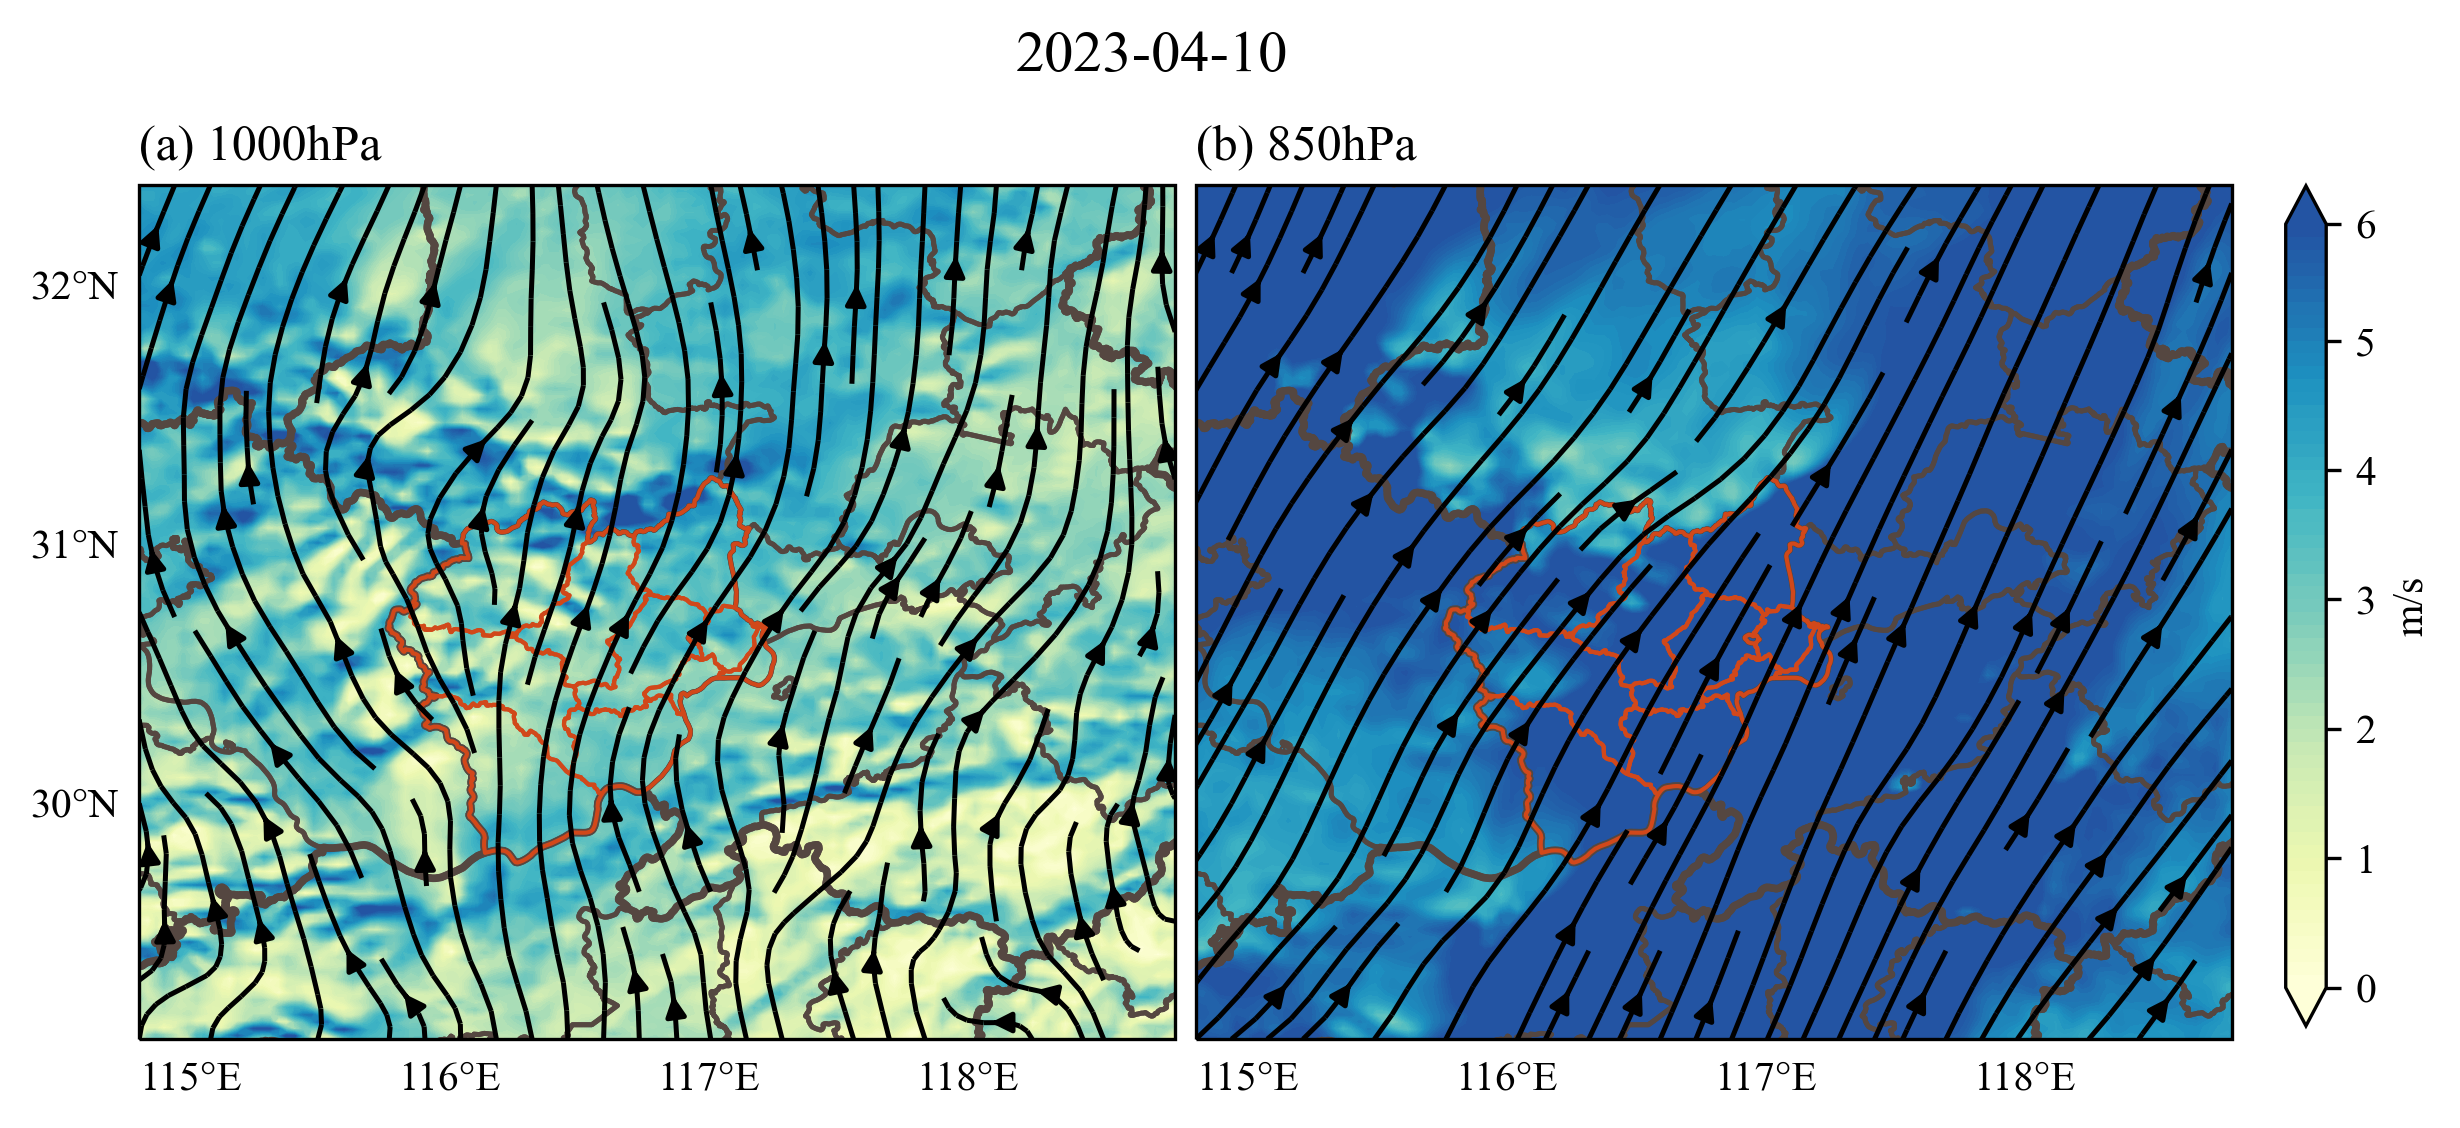

In [6]:
date=10
cmax=6
cmaplevel=np.arange(0,cmax,0.1)
proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
ax = fig.subplots(1,2,subplot_kw={'projection':proj})

shp = Reader('F:/Data/case_anqing/shapefile/Anqing_district/anqing_district.shp')
shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
shp_cit = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/3. City/city.shp')
for i in range(2):
    ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.8)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_cit.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.2)
    ax[i].add_feature(cfeat.ShapelyFeature(shp.geometries(),proj,edgecolor='#d1481a',facecolor='None'), linewidth=1)

    gl=ax[i].gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels =False
    gl.rotate_labels=False
    
    ax[i].set_extent([114.8, 118.8, 29.1, 32.4],ccrs.PlateCarree()) # d03

    if i>0:
        gl.left_labels=False

xgrid = np.size(uuL1,2)
ygrid = np.size(uuL1,1)
ngrid = 10

# contour map
cmap=ax[0].contourf(lon,lat,ws_L1[date-1,:,:],transform=proj,cmap=colormap,levels=cmaplevel,extend='both')
cmap=ax[1].contourf(lon,lat,ws_L2[date-1,:,:],transform=proj,cmap=colormap,levels=cmaplevel,extend='both')

ax[0].streamplot(lon[0:ygrid:ngrid,0:xgrid:ngrid].values,lat[0:ygrid:ngrid,0:xgrid:ngrid].values,
        uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,
        transform=proj,color='k',linewidth=1.2)
ax[1].streamplot(lon[0:ygrid:ngrid,0:xgrid:ngrid].values,lat[0:ygrid:ngrid,0:xgrid:ngrid].values,
        uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,
        transform=proj,color='k',linewidth=1.2)

# share colorbar
fig.subplots_adjust(right=0.9,wspace=0.02)
position= fig.add_axes([0.92,0.15,0.015,0.7])
cbar=fig.colorbar(cmap,cax=position)
cbar.set_ticks(np.arange(0,cmax+0.1,1))
cbar.set_label('m/s')

ax[0].set_title('(a) 1000hPa',loc='left')
ax[1].set_title('(b) 850hPa',loc='left')
plt.suptitle(pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'),size=14)

plt.show()

In [7]:
dates=np.arange(1,31)
cmax=6
cmaplevel=np.arange(0,cmax,0.1)
proj=ccrs.PlateCarree()

shp = Reader('F:/Data/case_anqing/shapefile/Anqing_district/anqing_district.shp')
shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
shp_cit = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/3. City/city.shp')

for date in dates:
    fig = plt.figure(figsize=(9,4),dpi=300)
    ax = fig.subplots(1,2,subplot_kw={'projection':proj})
    for i in range(2):
        ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.8)
        ax[i].add_feature(cfeat.ShapelyFeature(shp_cit.geometries(),proj,edgecolor='#554741',facecolor='None'), linewidth=1.2)
        ax[i].add_feature(cfeat.ShapelyFeature(shp.geometries(),proj,edgecolor='#d1481a',facecolor='None'), linewidth=1)

        gl=ax[i].gridlines(
                xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
                draw_labels=True, x_inline=False, y_inline=False,
                linewidth=0, linestyle='--', color='gray')
        gl.top_labels = False
        gl.right_labels =False
        gl.rotate_labels=False
    
        ax[i].set_extent([114.8, 118.8, 29.1, 32.4],ccrs.PlateCarree()) # d03

        if i>0:
            gl.left_labels=False

    xgrid = np.size(uuL1,2)
    ygrid = np.size(uuL1,1)
    ngrid = 10

    # contour map
    cmap=ax[0].contourf(lon,lat,ws_L1[date-1,:,:],transform=proj,cmap=colormap,levels=cmaplevel,extend='both')
    cmap=ax[1].contourf(lon,lat,ws_L2[date-1,:,:],transform=proj,cmap=colormap,levels=cmaplevel,extend='both')

    ax[0].streamplot(lon[0:ygrid:ngrid,0:xgrid:ngrid].values,lat[0:ygrid:ngrid,0:xgrid:ngrid].values,
            uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,
            transform=proj,color='k',linewidth=1.2)
    ax[1].streamplot(lon[0:ygrid:ngrid,0:xgrid:ngrid].values,lat[0:ygrid:ngrid,0:xgrid:ngrid].values,
            uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,
            transform=proj,color='k',linewidth=1.2)

    # share colorbar
    fig.subplots_adjust(right=0.9,wspace=0.02)
    position= fig.add_axes([0.92,0.15,0.015,0.7])
    cbar=fig.colorbar(cmap,cax=position)
    cbar.set_ticks(np.arange(0,cmax+0.1,1))
    cbar.set_label('m/s')

    ax[0].set_title('(a) 1000hPa',loc='left')
    ax[1].set_title('(b) 850hPa',loc='left')
    plt.suptitle(pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'),size=14)
    
    plt.savefig('D:/Download/ws_spa_'+pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'))
    print('saving figure on '+pd.to_datetime('2023-04-'+str(date)).strftime('%Y-%m-%d'))
    plt.close()
# plt.show()

saving figure on 2023-04-01
saving figure on 2023-04-02
saving figure on 2023-04-03
saving figure on 2023-04-04
saving figure on 2023-04-05
saving figure on 2023-04-06
saving figure on 2023-04-07
saving figure on 2023-04-08
saving figure on 2023-04-09
saving figure on 2023-04-10
saving figure on 2023-04-11
saving figure on 2023-04-12
saving figure on 2023-04-13
saving figure on 2023-04-14
saving figure on 2023-04-15
saving figure on 2023-04-16
saving figure on 2023-04-17
saving figure on 2023-04-18
saving figure on 2023-04-19
saving figure on 2023-04-20
saving figure on 2023-04-21
saving figure on 2023-04-22
saving figure on 2023-04-23
saving figure on 2023-04-24
saving figure on 2023-04-25
saving figure on 2023-04-26
saving figure on 2023-04-27
saving figure on 2023-04-28
saving figure on 2023-04-29
saving figure on 2023-04-30
